##### the goal is to build  a machine learning model that predicts the probability that the first transaction of a new user is fraudulent

In [52]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = os.getcwd()

In [3]:
data = pd.read_csv(path+'/Fraud_Data.csv')

In [15]:
data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [16]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None


In [22]:
## fix the ip_address
data['ip_address'] = round(data['ip_address'])

In [23]:
ip_addresses = pd.read_csv(path+'/IpAddress_to_Country.csv')
ip_addresses.head()


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


for each user, determine their country based on the IP address

In [25]:
len(ip_addresses['country'].values)

138846

In [32]:
data_country = [None] * data.shape[0]
  
for i in range(data.shape[0]):
       tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & 
                          (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])
                         ]['country'].values
       if (len(tmp) == 1):  
               data_country[i] = tmp
  
data['country'] = data_country
data['country'] = data['country'].str.get(0)
  
print(data.groupby('country').size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


In [33]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


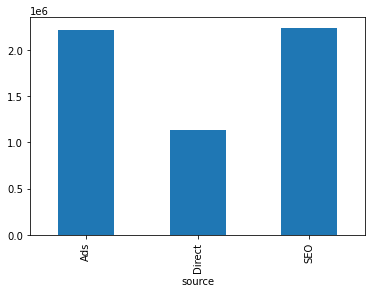

In [56]:
data.groupby(['source']).sum()['purchase_value'].plot(kind='bar')

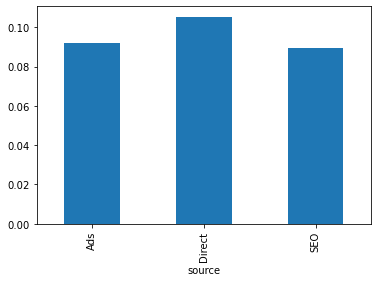

In [49]:
data.groupby(['source']).mean()['class'].plot(kind='bar')

Direct scourse has the lowest total revenue and most fraud activity than other 2 sources

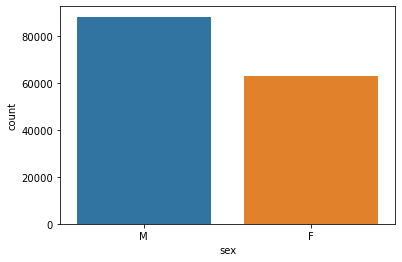

In [53]:
sns.countplot(x='sex',data=data)

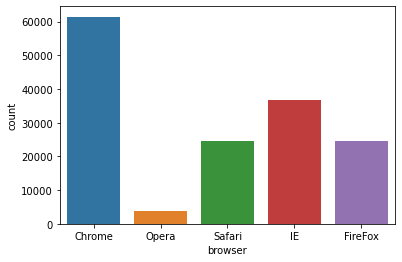

In [58]:
sns.countplot(x='browser',data=data[['class','browser']])

In [60]:
data.groupby(['browser']).mean()['class']

browser
Chrome     0.098792
FireFox    0.095165
IE         0.086775
Opera      0.089227
Safari     0.090201
Name: class, dtype: float64

Chrome browser has the highest fraud activities


some variables created for prediction:

1.Time diff between sign-up and purchase time 

2.device id is unique or certain users are sharing the same device

3.if many users having the same ip address coule be an indicator fake acct




In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(101)

In [69]:
#make date variables dates
data["signup_time"]   = pd.to_datetime(data["signup_time"])
data["purchase_time"] = pd.to_datetime(data["purchase_time"])

# get the date diff
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()

#chek how for each device id, how many different users belong to it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')

#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

In [70]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_id_count,ip_address_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1


In [71]:
#data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)

In [76]:
data_rf.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'ip_address',
       'class', 'country', 'purchase_signup_diff', 'device_id_count',
       'ip_address_count'],
      dtype='object')

In [78]:
data_rf.info()
# country variable has None value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   purchase_value        151112 non-null  int64  
 1   source                151112 non-null  object 
 2   browser               151112 non-null  object 
 3   sex                   151112 non-null  object 
 4   age                   151112 non-null  int64  
 5   ip_address            151112 non-null  float64
 6   class                 151112 non-null  int64  
 7   country               129146 non-null  object 
 8   purchase_signup_diff  151112 non-null  float64
 9   device_id_count       151112 non-null  int64  
 10  ip_address_count      151112 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 12.7+ MB


In [80]:
#replace None in the country var with "Not_found"
data_rf['country'].replace([None], "Not_found", inplace=True)
data_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   purchase_value        151112 non-null  int64  
 1   source                151112 non-null  object 
 2   browser               151112 non-null  object 
 3   sex                   151112 non-null  object 
 4   age                   151112 non-null  int64  
 5   ip_address            151112 non-null  float64
 6   class                 151112 non-null  int64  
 7   country               151112 non-null  object 
 8   purchase_signup_diff  151112 non-null  float64
 9   device_id_count       151112 non-null  int64  
 10  ip_address_count      151112 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 12.7+ MB


In [85]:
data_rf['country'].unique().size
# we want to just keep top 50 countries, everythong else is 'other'

182

In [91]:
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)

In [92]:
# make dummy
data_rf = pd.get_dummies(data_rf, drop_first = True)

In [93]:
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)

In [94]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])

RandomForestClassifier(max_features=3, oob_score=True)

In [95]:
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9554711078579808 
 OOB Confusion Matrix 
        0     1
0  90173    89
1   4352  5119


In [96]:
#let's print test accuracy and confusion matrix

print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9573755814632438 
 Test Set Confusion Matrix 
        0     1
0  46671    28
1   2162  2518


the confusion matrix looks good, we are not overfitting because OOB and test results are very similar. Since we need to seek a trade off between false negative and false positive, this usually implies building the ROC and look for possible cut-off points. 

In [106]:
#Predictions as probabilities We can double check that with a 0.5 cut-off we get the same results shown by rf output(since random forest internally uses 0.5)
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))

print(np.array_equal(pred_prob.round(), pred))

True


In [ ]:
## however, is really 0.5 the best possible cut-off?  we need to look at roc curve

In [107]:
from sklearn.metrics import roc_curve

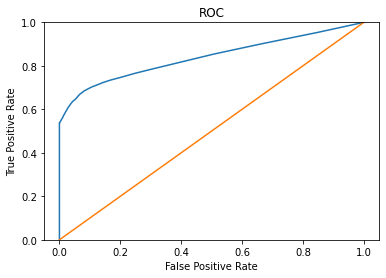

In [112]:
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

according to the ROC curve, if we care about minimizing false positive, we would choose a cut-off which would give us true positive rate near 0.6 and false positive rate 0. However, if we care about maximizing true positive rate, we would have to decrease the cut-off, in which way we classify more events as '1'(some will be true ones so true positive goes up and many will be false ones so false positive will also go up)

##### Next step:

after the model is used live to predict in real time if an activity is fraudulent or not, we will have some misclassifications, it's crucial to minimize this misclassification impact. We can create different experiences based on the model score, for instance:

if predicted fraud probability < X, the user has the normal experience(majority user)

if X <= predicted fraud probability < Y (the user is risk but not too much), we can create additional verification step, like phone number verifications via a code sent by SMS 

if predicted fraud probability >= Y(really likely the user is commited as a fraud), we can tell user his activity has been put on hold, sent this user info to someone who can review it mannually to decide whether to block this user or not.

